🎯 **TALLER 1: SERIES DE TIEMPO**

📅 **Fecha:** 2025

👤 **Equipo:** [Hector Hernan Betancourt Lopez - Marcela Fajardo Bermúdez]

#### * Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

## **1. Importación de librerias**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


## **2. Carga de datos y vista rápida**

In [2]:
data = pd.read_excel("C:/Users/mafab/Documents/Fundamentos_Analitica/Series_de_tiempo/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head(3)

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120


(222, 4)


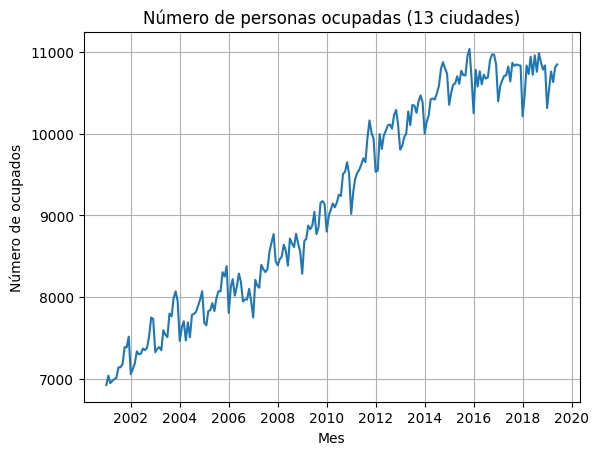

In [3]:
# Dimensiones del dataframe
print(data.shape)

# Graficando los datos
plt.title("Número de personas ocupadas (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Número de ocupados")
plt.plot(data[['Ocupados']])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

Se procede a descomponer la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**.

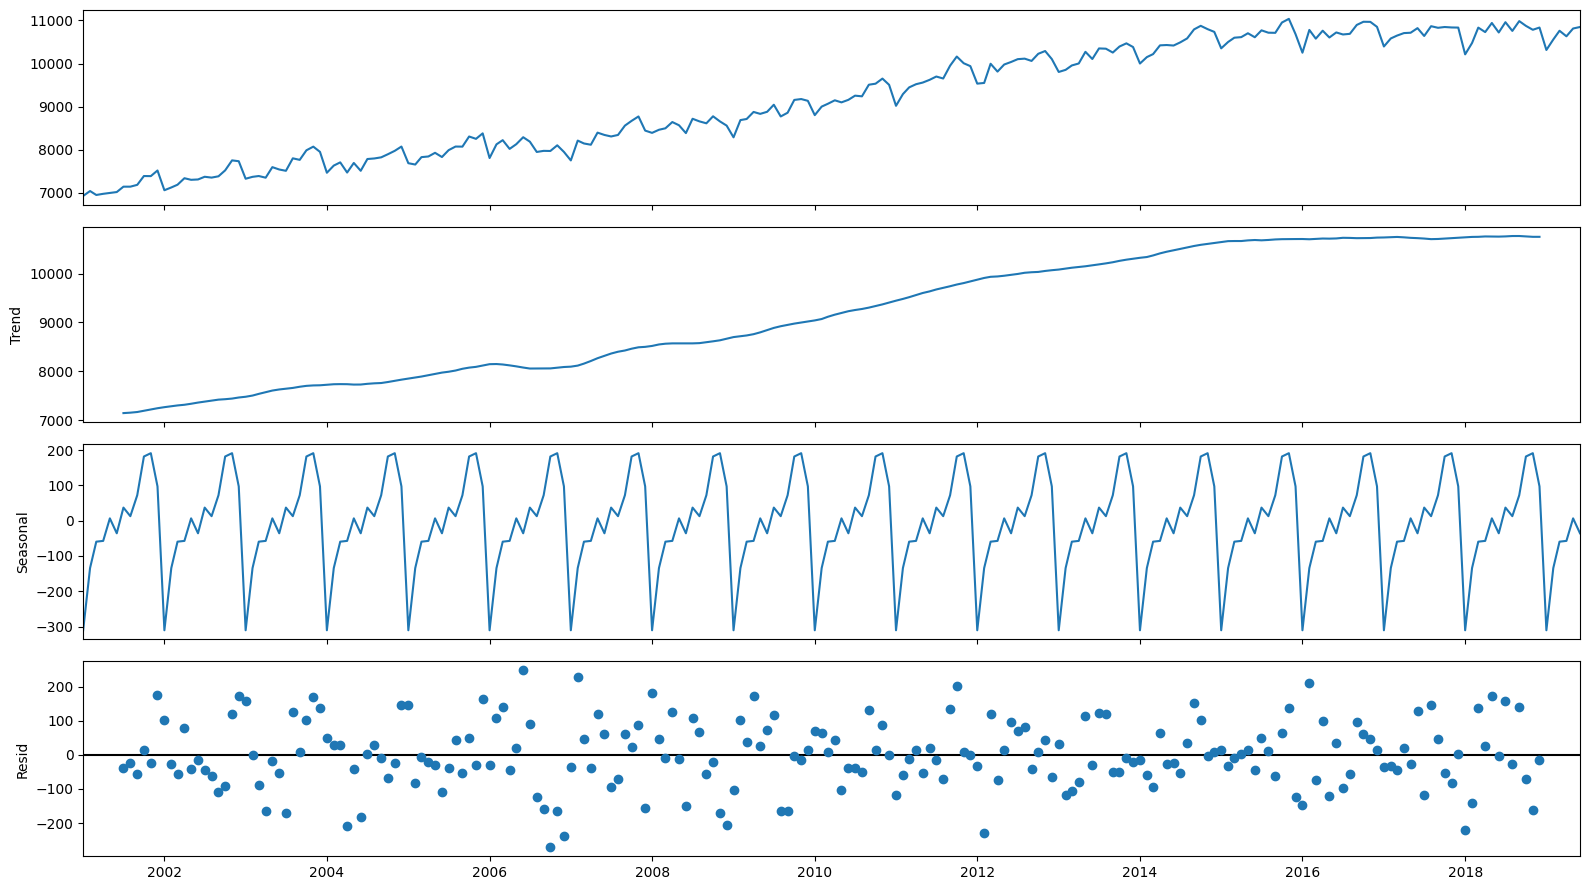

In [4]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [5]:
td_componentes.seasonal
# td_componentes.trend
# td_componentes.resid

mes
2001-01-01   -310.570069
2001-02-01   -134.331549
2001-03-01    -59.585841
2001-04-01    -57.385905
2001-05-01      6.435912
                 ...    
2019-02-01   -134.331549
2019-03-01    -59.585841
2019-04-01    -57.385905
2019-05-01      6.435912
2019-06-01    -35.859993
Name: seasonal, Length: 222, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia lineal de los datos.

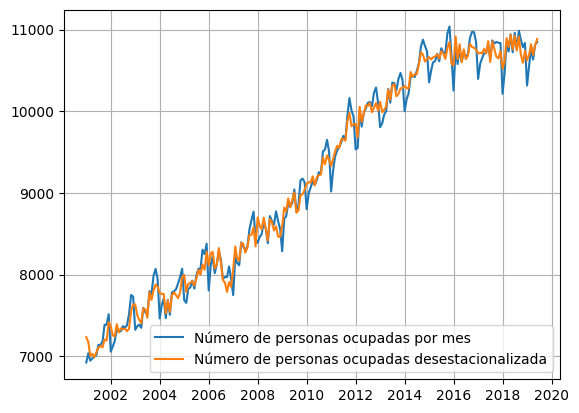

In [6]:
td_desestacionalizada = data['Ocupados']-td_componentes.seasonal

plt.plot(data[['Ocupados']],label="Número de personas ocupadas por mes")
plt.plot(td_desestacionalizada,label="Número de personas ocupadas desestacionalizada")
plt.legend()
plt.grid()
plt.show()


### **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

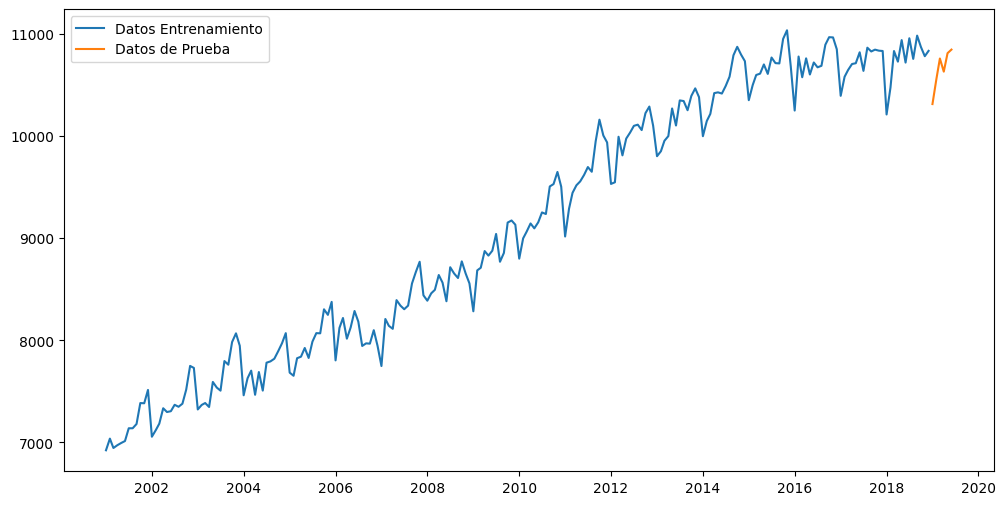

In [7]:
train_len = 216
h = 6
train_td = data[['Ocupados']][:train_len]
test_td = data[['Ocupados']][train_len:train_len+h]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [8]:
train_td

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338


In [9]:
test_td

,Ocupados
mes,
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028
2019-05-01,10813.000
2019-06-01,10848.000


## **4.1 Promedio movil**

In [10]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()
ma_6= train_td.rolling(6,min_periods=2).mean()
ma_7= train_td.rolling(7,min_periods=2).mean()

In [11]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()
ma_6= train_td.shift().rolling(6,min_periods=2).mean()
ma_7= train_td.shift().rolling(7,min_periods=2).mean()

In [12]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [13]:
ma_2_f= fore_ma(train_td,2,6)
ma_3_f= fore_ma(train_td,3,6)
ma_4_f= fore_ma(train_td,4,6)
ma_5_f= fore_ma(train_td,5,6)
ma_6_f= fore_ma(train_td,6,6)
ma_7_f= fore_ma(train_td,7,6)

In [14]:
test_td

,Ocupados
mes,
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028
2019-05-01,10813.000
2019-06-01,10848.000


In [15]:
ma_2_f

,Ocupados
mes,
2019-01-01,10809.348500
2019-02-01,10822.373250
2019-03-01,10815.860875
2019-04-01,10819.117063
2019-05-01,10817.488969
2019-06-01,10818.303016


In [16]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_td,ma_6_f ))
rmse_ma_7 = np.sqrt(mean_squared_error(test_td,ma_7_f ))

In [17]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5, rmse_ma_6, rmse_ma_7)

242.8347290019203 250.36984465630144 270.6203851653251 266.5247179311155 272.83744069293607 269.605171526337


* **Nota:**

El menor error corresponde al modelo de promedio móvil con ventana de 2 meses(rmse_ma_2), ya que significa que el pronóstico tiene, en promedio, menos error respecto a los datos reales del periodo de prueba

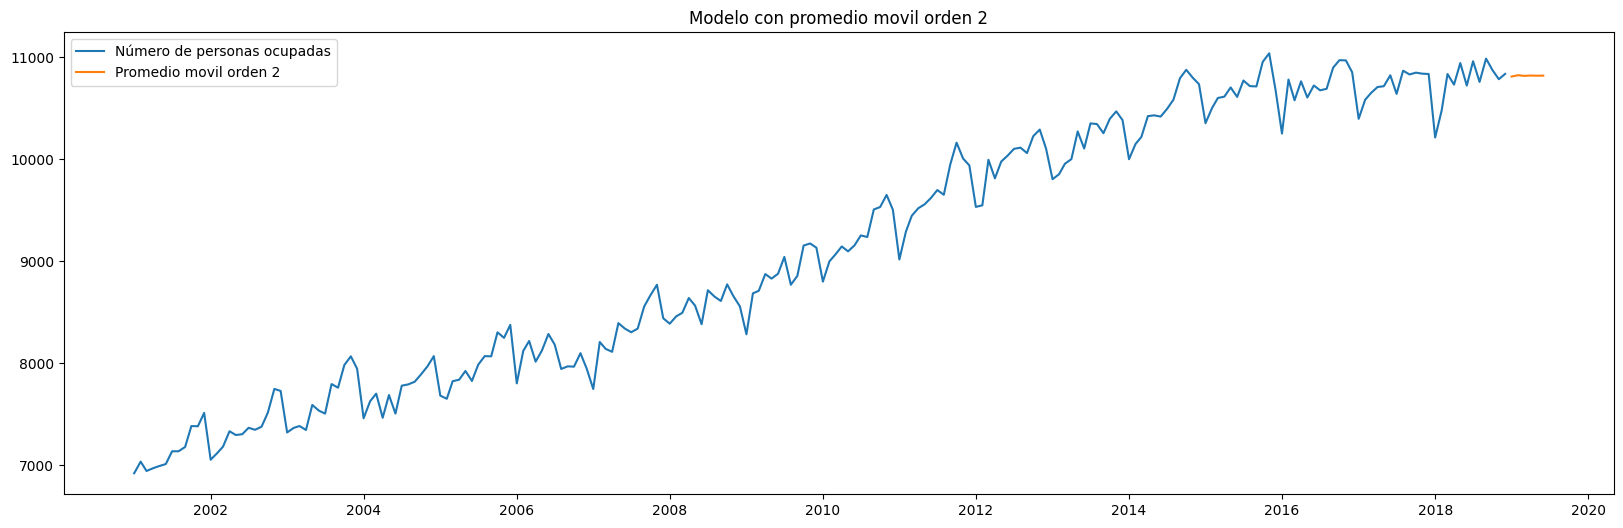

In [18]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Número de personas ocupadas")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend()
plt.title('Modelo con promedio movil orden 2')
plt.show()

## **4.2 Suavizacion Exponencial Simple**

In [19]:
ets_model = ETSModel(endog=train_td['Ocupados'],error="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2019-01-01    10830.738566  10476.461342  11185.015789
2019-02-01    10830.738566  10411.310113  11250.167018
2019-03-01    10830.738566  10354.999034  11306.478098
2019-04-01    10830.738566  10304.681555  11356.795576
2019-05-01    10830.738566  10258.773659  11402.703472
2019-06-01    10830.738566  10216.286184  11445.190948


c:\Users\mafab\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
print(f"Alpha (Nivel): {ets_result.alpha}")

Alpha (Nivel): 0.6337324797008803


In [21]:
rmse = np.sqrt(mean_squared_error(test_td,point_forecast))
print(rmse)

253.63725552730503


* **Nota:**

En esta caso el α estimado es 0.6337323614899885 Y el RMSE en la muestra de evaluación es 253.63725759469287

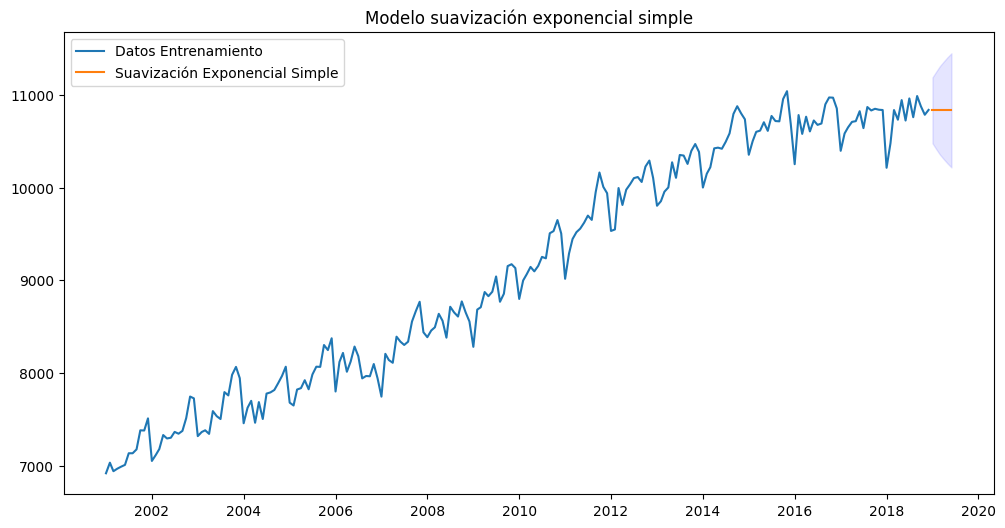

In [22]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title('Modelo suavización exponencial simple')
plt.show()

## **4.3 Suavizacion Exponencial Lineal (Holt)**

In [23]:
ets_model = ETSModel(endog=train_td['Ocupados'],error="mul",trend="mul")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2019-01-01    10876.157755  10437.674640  11276.924850
2019-02-01    10899.800287  10445.591500  11385.958656
2019-03-01    10923.494214  10363.847208  11438.329756
2019-04-01    10947.239647  10337.733715  11502.977738
2019-05-01    10971.036697  10365.976756  11639.832518
2019-06-01    10994.885477  10347.926789  11688.586681


c:\Users\mafab\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
print(f"Alpha (Nivel): {ets_result.alpha}")
print(f"Beta (Tendencia): {ets_result.beta}")

Alpha (Nivel): 0.5506166259155781
Beta (Tendencia): 5.506166259155782e-05


In [25]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

317.4901061727439


* **Nota:**

En esta caso el α estimado es 0.5506151066219966 y el β estimado es 5.506151066219967$^{-5}$. Y el RMSE en la muestra de evaluación es 317.489885721014

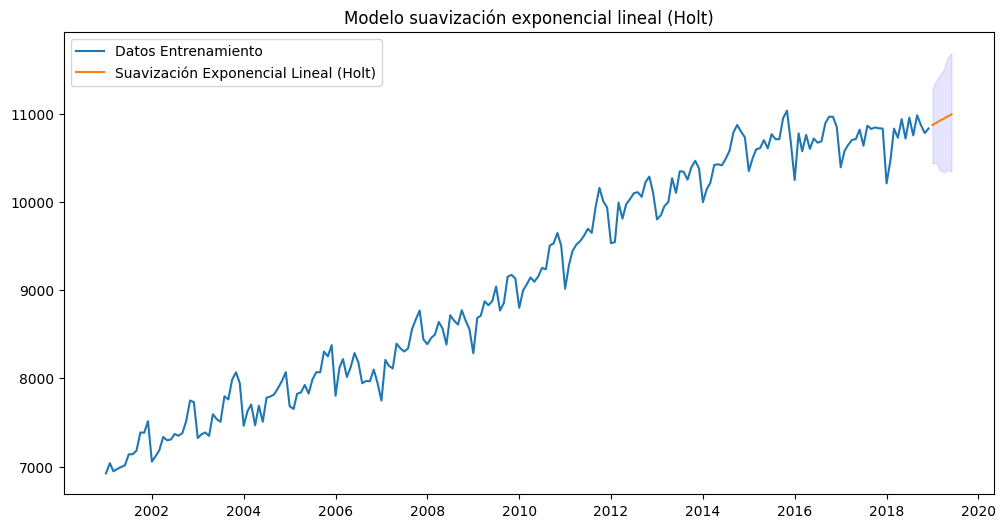

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title('Modelo suavización exponencial lineal (Holt)')
plt.show()

## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [27]:
# Build model
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2019-01-01    10349.066094  10090.566259  10607.565928
2019-02-01    10624.669899  10350.514445  10898.825354
2019-03-01    10770.096090  10481.129086  11059.063093
2019-04-01    10786.237896  10483.179629  11089.296163
2019-05-01    10870.805531  10554.280073  11187.330989
2019-06-01    10828.745263  10499.300145  11158.190381


c:\Users\mafab\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
print(f"Alpha (Nivel): {ets_result.alpha}")
print(f"Beta (Tendencia): {ets_result.beta}")
print(f"Gamma (Estacionalidad): {ets_result.gamma}")

Alpha (Nivel): 0.3532275373351325
Beta (Tendencia): 3.532275373351325e-05
Gamma (Estacionalidad): 0.2970519514975667


In [29]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td[:6],preds_hw_add['Point_forecast']))
print(rmse_hw_add)

74.42539315021223


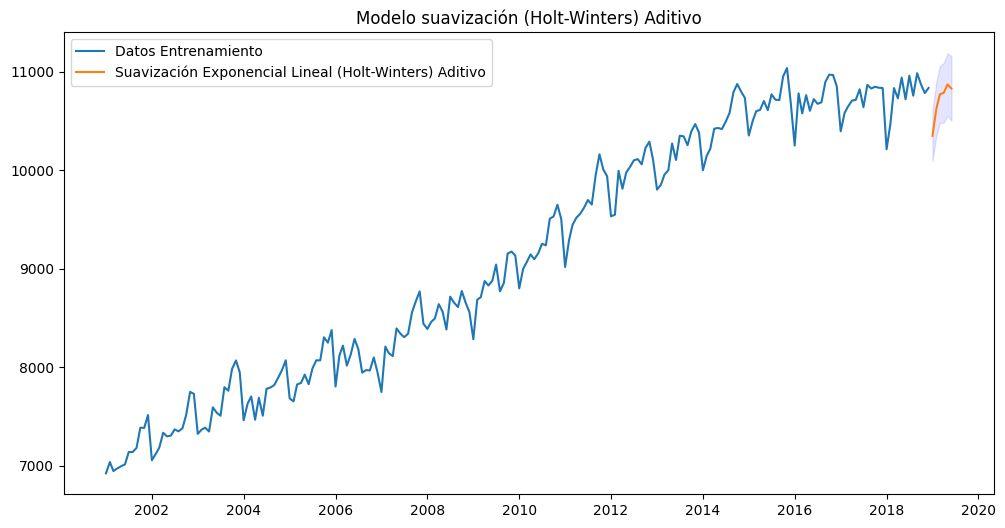

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title('Modelo suavización (Holt-Winters) Aditivo')
plt.show()

## **Suavización exponencial sin tendencia y estacionalidad multiplicativa**

In [31]:
# Build model.
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2019-01-01    10325.781771  10090.647161  10563.010786
2019-02-01    10527.749195  10261.059955  10806.094898
2019-03-01    10611.310492  10312.937585  10931.681331
2019-04-01    10620.935074  10309.169939  10941.954443
2019-05-01    10689.617894  10328.109486  11049.104618
2019-06-01    10645.660941  10257.772573  11029.371751


c:\Users\mafab\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
print(f"Alpha (Nivel): {ets_result.alpha}")
print(f"Gamma (Estacionalidad): {ets_result.gamma}")

Alpha (Nivel): 0.5975177329815669
Gamma (Estacionalidad): 4.024822670184332e-05


In [33]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td[:6],preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

115.22876353569147


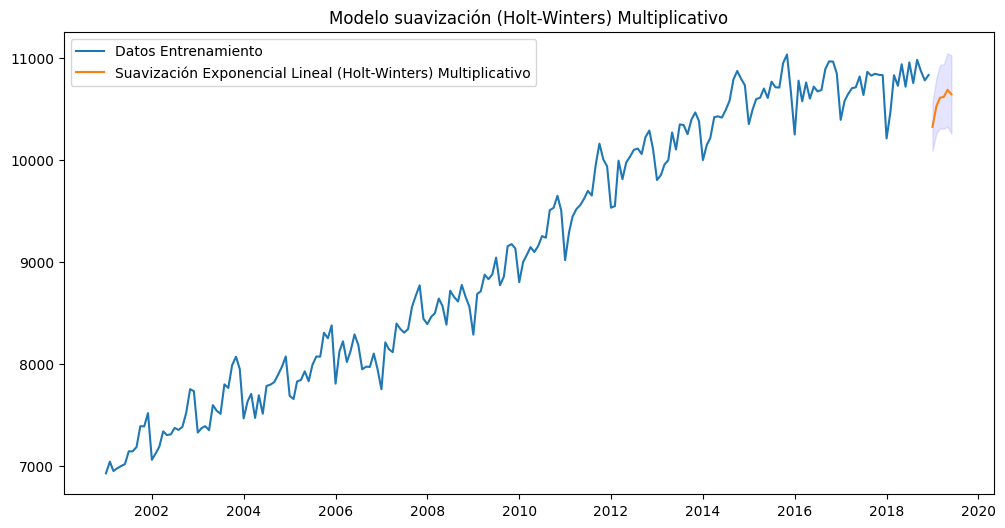

In [34]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title('Modelo suavización (Holt-Winters) Multiplicativo')
plt.show()

## **5. Comparación de modelos**

In [35]:
rmse_comparison = {
    'Modelo': [],
    'RMSE': []
}

# RMSE del Promedio Móvil
rmse_comparison['Modelo'].append('Promedio Móvil (Orden 2)')
rmse_comparison['RMSE'].append(rmse_ma_2)
rmse_comparison['Modelo'].append('Promedio Móvil (Orden 3)')
rmse_comparison['RMSE'].append(rmse_ma_3)
rmse_comparison['Modelo'].append('Promedio Móvil (Orden 4)')
rmse_comparison['RMSE'].append(rmse_ma_4)
rmse_comparison['Modelo'].append('Promedio Móvil (Orden 5)')
rmse_comparison['RMSE'].append(rmse_ma_5)
rmse_comparison['Modelo'].append('Promedio Móvil (Orden 6)')
rmse_comparison['RMSE'].append(rmse_ma_6)
rmse_comparison['Modelo'].append('Promedio Móvil (Orden 7)')
rmse_comparison['RMSE'].append(rmse_ma_7)


# RMSE de la Suavización Exponencial Simple
rmse_comparison['Modelo'].append('Suavización Exponencial Simple')
rmse_comparison['RMSE'].append(rmse) # Asumiendo que 'rmse' almacena el RMSE de SES

# RMSE de la Suavización Exponencial Lineal (Holt)
rmse_comparison['Modelo'].append('Suavización Exponencial Lineal (Holt)')
rmse_comparison['RMSE'].append(rmse_holt) # Asumiendo que 'rmse_holt' almacena el RMSE de Holt

# RMSE de Holt-Winters (Aditivo)
rmse_comparison['Modelo'].append('Holt-Winters (Aditivo)')
rmse_comparison['RMSE'].append(rmse_hw_add) # Asumiendo que 'rmse_hw_add' almacena el RMSE de HW Aditivo

# RMSE de Holt-Winters (Multiplicativo)
rmse_comparison['Modelo'].append('Holt-Winters (Multiplicativo)')
rmse_comparison['RMSE'].append(rmse_hw_mul) # Asumiendo que 'rmse_hw_mul' almacena el RMSE de HW Multiplicativo

# Crear un DataFrame de pandas
rmse_df = pd.DataFrame(rmse_comparison)

# Ordenar por RMSE
rmse_df = rmse_df.sort_values(by='RMSE')

# Mostrar la tabla
display(rmse_df)

,Modelo,RMSE
8,Holt-Winters (Aditivo),74.425393
9,Holt-Winters (Multiplicativo),115.228764
0,Promedio Móvil (Orden 2),242.834729
1,Promedio Móvil (Orden 3),250.369845
6,Suavización Exponencial Simple,253.637256
3,Promedio Móvil (Orden 5),266.524718
5,Promedio Móvil (Orden 7),269.605172
2,Promedio Móvil (Orden 4),270.620385
4,Promedio Móvil (Orden 6),272.837441
7,Suavización Exponencial Lineal (Holt),317.490106


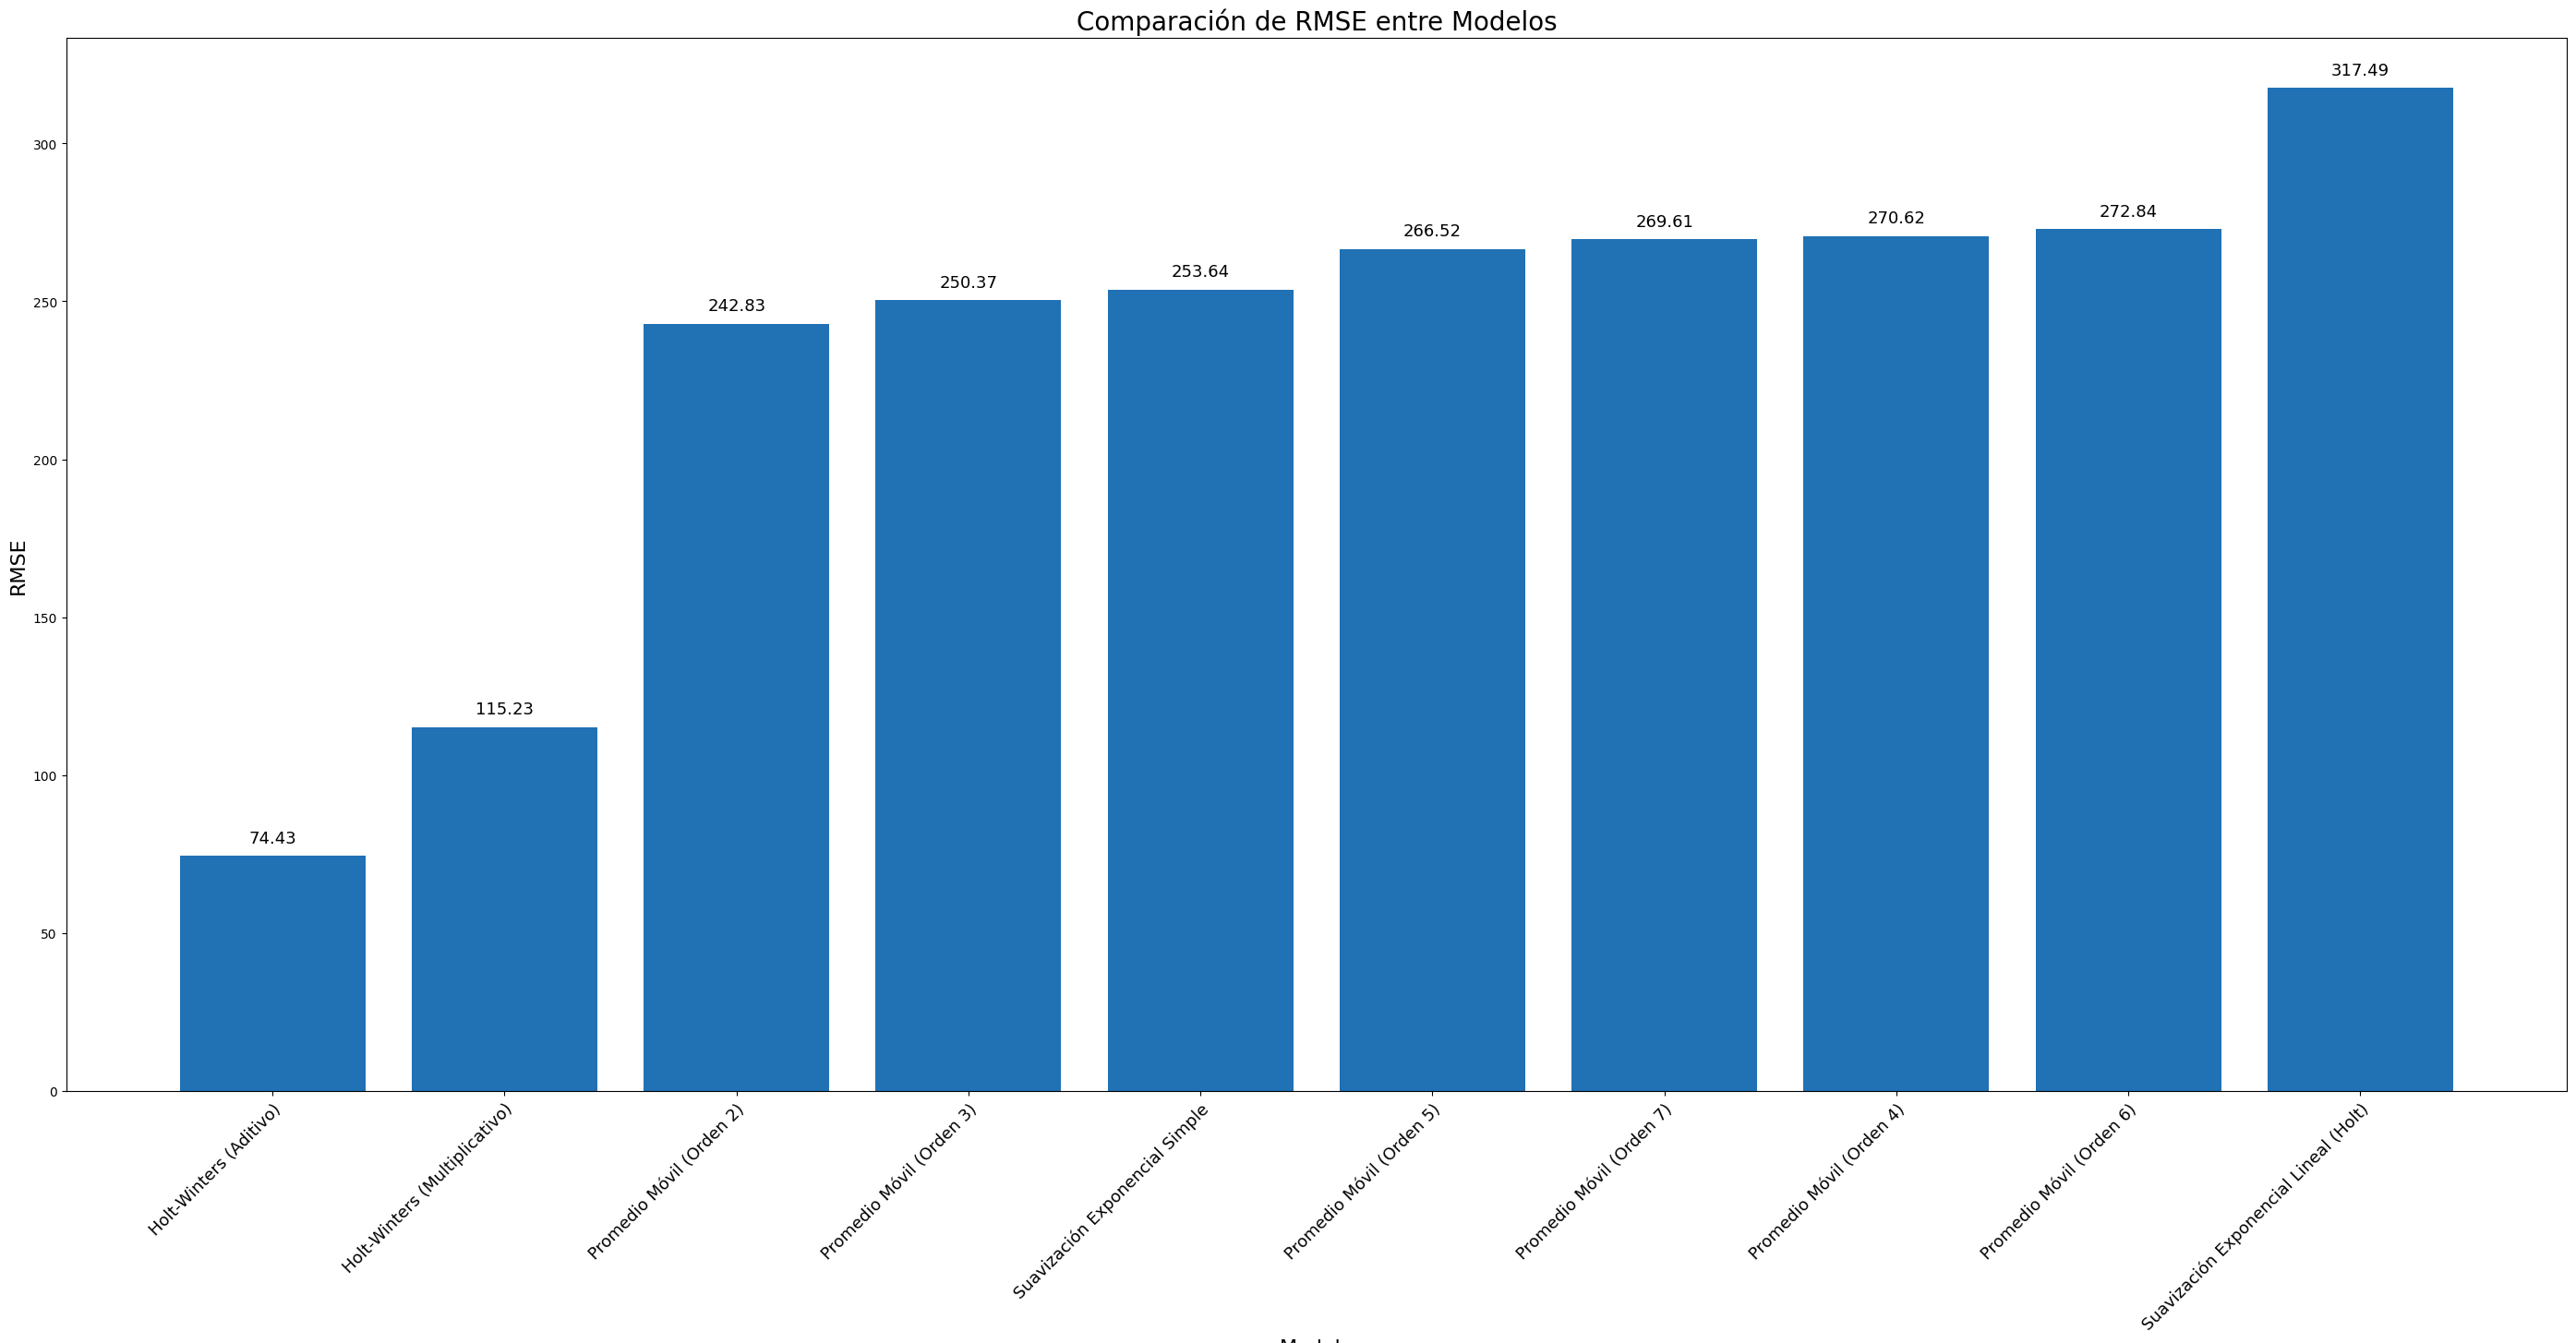

In [36]:
plt.figure(figsize=(28, 14))
bars = plt.bar(rmse_df['Modelo'], rmse_df['RMSE'], color='#2171b5')

# Mejor rotación y alineación, fuente grande
plt.xticks(rotation=45, ha='right', fontsize=13, wrap=True)

plt.xlabel("Modelo", fontsize=16)
plt.ylabel("RMSE", fontsize=16)
plt.title("Comparación de RMSE entre Modelos", fontsize=20)

# Etiquetas numéricas encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3,
             f'{yval:.2f}', ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

## **6. Suavización Exponencial All Data**

### Se ajusta el modelo con el train y se observan los hiperparametros obtenidos en la optimización

In [37]:
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend="add",seasonal="add")
ets_result = ets_model.fit()

c:\Users\mafab\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
print(ets_result.alpha)
print(ets_result.beta)
print(ets_result.gamma)
print(ets_result.param_names)

0.3532275373351325
3.532275373351325e-05
0.2970519514975667
['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']


In [39]:
## Se ajusta el modelo final con todos los datos

final_model = ETSModel(endog=data['Ocupados'],error="add",trend="add",seasonal="add")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.3532275373351325,'smoothing_trend': 3.532275373351325e-05,'smoothing_seasonal':0.2970519514975667})

print("Modelo final ajustado con todos los datos.")

print(final_model_fit.alpha)
print(final_model_fit.beta)
print(final_model_fit.gamma)

Modelo final ajustado con todos los datos.
0.3532275373351325
3.532275373351325e-05
0.2970519514975667


c:\Users\mafab\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## **7. Pronóstico**

In [40]:
point_forecast=final_model_fit.forecast(6)

ci = final_model_fit.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
display(preds_hw_add)

,Point_forecast,lower_95,upper_95
2019-07-01,10878.292656,10635.443088,11121.142225
2019-08-01,10872.244151,10614.686795,11129.801506
2019-09-01,11000.168602,10728.696428,11271.640777
2019-10-01,11032.567742,10747.857427,11317.278058
2019-11-01,11036.249384,10738.887217,11333.611551
2019-12-01,11000.273555,10690.773918,11309.773191


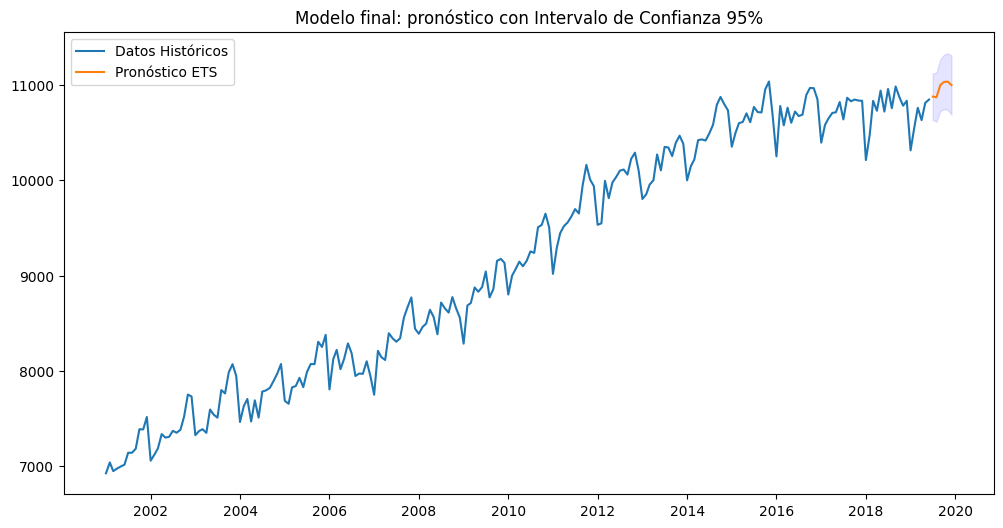

In [41]:
fig = plt.figure(figsize=(12, 6))

# Serie histórica completa de Ocupados
plt.plot(data.index, data['Ocupados'], label="Datos Históricos")

# Pronóstico puntual (6 meses)
plt.plot(preds_hw_add.index, preds_hw_add['Point_forecast'], label="Pronóstico ETS")

# Intervalo de confianza 95%
plt.fill_between(preds_hw_add.index,
                 preds_hw_add['lower_95'],
                 preds_hw_add['upper_95'],
                 color='blue', alpha=0.1)

plt.legend()
plt.title('Modelo final: pronóstico con Intervalo de Confianza 95%')
plt.show()